In [1]:
import dask.dataframe as dd
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pickle
import joblib

In [2]:
# reading the data of a dask directory and converting into a pandas dataframe
def read_dd_to_pandas(route):
    route_dask_df = dd.read_csv("~/data/leavetimes_split_by_route/{}/*.part".format(route))
    route_dask_df = route_dask_df.drop('Unnamed: 0', axis=1)
    route_pd_df = route_dask_df.compute()
    route_pd_df = route_pd_df.reset_index(drop=True)
    route_pd_df["DAYOFSERVICE"] = pd.to_datetime(route_pd_df["DAYOFSERVICE"])
    route_pd_df["LASTUPDATE"] = pd.to_datetime(route_pd_df["LASTUPDATE"])
    return route_pd_df

In [3]:
route_pd_df = read_dd_to_pandas("route102")

In [4]:
# datetime things
route_pd_df["DAYOFSERVICE"] = pd.to_datetime(route_pd_df["DAYOFSERVICE"])
route_pd_df["LASTUPDATE"] = pd.to_datetime(route_pd_df["LASTUPDATE"])

# categorical things
route_pd_df["TRIPID"] = route_pd_df["TRIPID"].astype("category")
route_pd_df["VEHICLEID"] = route_pd_df["VEHICLEID"].astype("category")
route_pd_df["SUPPRESSED"] = route_pd_df["SUPPRESSED"].astype("category")
route_pd_df["STOPPOINTID"] = route_pd_df["STOPPOINTID"].astype("category")
#route_pd_df["PROGRNUMBER"] = route_pd_df["PROGRNUMBER"].astype("category")

# NUMBERICAL tings
# these are the time features, will keep these the same as before

In [5]:
# read weather data
weather_df = pd.read_csv("~/data/openweatherapi_2018_data_with_columns_removed2021-06-26 01:55:47.555341.csv")
#weather_df = weather_df.drop("Unnamed: 0", axis = 1)

# change the dtypes of the weather features
weather_df["dt"] = pd.to_datetime(weather_df["dt"]).dt.tz_localize(None)

# categorical data
weather_df["weather_main"] = weather_df["weather_main"].astype("category")
weather_df["weather_icon"] = weather_df["weather_icon"].astype("category")


In [6]:
# we need to merge the data for the route and the weather data
#merge with respect to the time, and eazch hour
# for example, 1:30 should be emrged with the data for 1:00 as weather
# is on hourly basis

# CREATE  a new feature in the routes that contains the hours so that we can 
# merge with the weather data
route_time_planned = route_pd_df["PLANNEDTIME_ARR"]
route_time_actual = route_pd_df["ACTUALTIME_ARR"]

actual_time_hour = []
expected_time_hour = []
for i in range(len(route_time_actual)):
    actual_time_hour.append(route_time_actual[i] // 3600)
    expected_time_hour.append(route_time_planned[i] // 3600)

actual_date = route_pd_df["DAYOFSERVICE"]


# parse it into datetime with this  any hours
date_time = []
for i in range(len(actual_time_hour)):
    new_datetime = actual_date[i] + timedelta(hours = int(actual_time_hour[i]))
    date_time.append(new_datetime)
    
# add in the new column, 
# new column means that we can remove the other date column
route_pd_df["date_and_time"] = date_time

route_pd_df["delay_amount"] = route_pd_df["ACTUALTIME_ARR"] - route_pd_df["PLANNEDTIME_ARR"]

#combined_df["planned_hour_arr"]
hours = route_pd_df["PLANNEDTIME_ARR"]//3600
#combined_df["planned_minute_arr"]

minutes= (route_pd_df["PLANNEDTIME_ARR"]%3600) // 60

route_pd_df["planned_arr_hours"] = hours
route_pd_df["planned_arr_minutes"] = minutes
# get the day of the week form the 
route_pd_df["day_of_week"] = route_pd_df["DAYOFSERVICE"].dt.day_name()

In [7]:
def holiday(df):
    holiday = [6,7,8, 12]
    if df["DAYOFSERVICE"].month in holiday:
        return 1
    elif df["DAYOFSERVICE"].month == 3 and df["DAYOFSERVICE"].day == 17:
        return 1
    elif df["DAYOFSERVICE"].month == 1 and df["DAYOFSERVICE"].day == 1:
        return 1
    elif df["DAYOFSERVICE"].month == 5 and df["DAYOFSERVICE"].day == 1:
        return 1
    else:
        return 0

In [8]:
route_pd_df["holiday"] = route_pd_df.apply(holiday, axis = 1)

In [9]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 21:00:00,-28,21,35,Monday,1
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,1,23,0,Monday,1
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,0,23,30,Monday,1
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,NaN,2018-01-08 17:21:10,2018-01-01 11:00:00,26,11,45,Monday,1
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,NaN,2018-01-08 17:21:10,2018-01-01 13:00:00,-2,13,25,Monday,1


In [12]:
outlier_df = route_pd_df[abs(route_pd_df["delay_amount"]) > 1800].reset_index(drop=True)
outlier_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday
0,2018-01-02,5961428,53,7348,47096,47096,48901,48901,1000204,NaN,NaN,2018-01-09 20:18:05,2018-01-02 13:00:00,1805,13,4,Tuesday,0
1,2018-01-02,5972140,18,6117,52480,52480,54722,54813,1932349,NaN,NaN,2018-01-09 20:18:05,2018-01-02 15:00:00,2242,14,34,Tuesday,0
2,2018-01-09,6102162,53,7348,47096,47096,49206,49206,1000198,NaN,NaN,2018-01-17 07:58:19,2018-01-09 13:00:00,2110,13,4,Tuesday,0
3,2018-01-30,6245294,43,3598,29260,29260,31326,31333,1000186,NaN,NaN,2018-02-08 14:07:43,2018-01-30 08:00:00,2066,8,7,Tuesday,0
4,2018-01-30,6239883,54,4381,82740,82740,84647,84647,2868363,NaN,NaN,2018-02-08 14:07:43,2018-01-30 23:00:00,1907,22,59,Tuesday,0


In [52]:
# would like to include suppressed, but in the 2021 data,
# as this is an indicator that the bus has some fault, or that something is wrong
#there may be no way of getting this
# so no point yusing features that we cannot use to test
suppressed_indicator = []
for element in route_pd_df["SUPPRESSED"]:
    if math.isnan(element):
        suppressed_indicator.append(0)
    else:
        suppressed_indicator.append(1)
route_pd_df["suppressed_id"] = suppressed_indicator

In [14]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 21:00:00,-28,21,35,Monday,1,0
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,1,23,0,Monday,1,0
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,0,23,30,Monday,1,0
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,NaN,2018-01-08 17:21:10,2018-01-01 11:00:00,26,11,45,Monday,1,0
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,NaN,2018-01-08 17:21:10,2018-01-01 13:00:00,-2,13,25,Monday,1,0


In [16]:
prog_id = route_pd_df["PROGRNUMBER"].unique()

In [17]:
prog_id

array([ 2,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

# thoughts on the model

## time series

if we do not include the weather data, the best thing we cna do is a time series analysis, so what we could do is add the expected arrival time to the date, and use it to predict the delay amount

We copuld create another model that uses features frem the dataset and the weather data

In [10]:
def seconds_to_time(n):
    return timedelta(seconds=n)

In [11]:
route_pd_df[ "datetime_exact"] = route_pd_df["DAYOFSERVICE"] + pd.Series(map(seconds_to_time, route_pd_df["PLANNEDTIME_ARR"]), name="time")

In [20]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 21:00:00,-28,21,35,Monday,1,0,2018-01-01 21:35:43
1,2018-01-01,5968222,2,935,82843,82843,82844,82844,2534829,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,1,23,0,Monday,1,0,2018-01-01 23:00:43
2,2018-01-01,5957733,2,935,84643,84643,84643,84643,2868314,NaN,NaN,2018-01-08 17:21:10,2018-01-01 23:00:00,0,23,30,Monday,1,0,2018-01-01 23:30:43
3,2018-01-01,5968214,1,4381,42300,42300,42326,42326,1001151,NaN,NaN,2018-01-08 17:21:10,2018-01-01 11:00:00,26,11,45,Monday,1,0,2018-01-01 11:45:00
4,2018-01-01,5957726,1,4381,48300,48300,48298,48298,1000198,NaN,NaN,2018-01-08 17:21:10,2018-01-01 13:00:00,-2,13,25,Monday,1,0,2018-01-01 13:25:00


In [21]:
# remove outliers where the delay amount is restricted to a 30 min interval
no_outlier_df = route_pd_df[abs(route_pd_df["delay_amount"]) < 1800].reset_index(drop=True)
no_outlier_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211,NaN,NaN,2018-01-08 17:21:10,2018-01-01 13:00:00,-18,13,20,Monday,1,0,2018-01-01 13:20:30
1,2018-01-01,5966674,12,119,54001,54001,54023,54023,2693267,NaN,NaN,2018-01-08 17:21:10,2018-01-01 15:00:00,22,15,0,Monday,1,0,2018-01-01 15:00:01
2,2018-01-01,5959105,12,119,60001,60001,59955,59955,2693263,NaN,NaN,2018-01-08 17:21:10,2018-01-01 16:00:00,-46,16,40,Monday,1,0,2018-01-01 16:40:01
3,2018-01-01,5966888,12,119,58801,58801,58771,58771,2693284,NaN,NaN,2018-01-08 17:21:10,2018-01-01 16:00:00,-30,16,20,Monday,1,0,2018-01-01 16:20:01
4,2018-01-01,5965960,12,119,56401,56401,56309,56323,2693209,NaN,NaN,2018-01-08 17:21:10,2018-01-01 15:00:00,-92,15,40,Monday,1,0,2018-01-01 15:40:01


# time series analysis

using facebook prophet to copnduct time series analysis

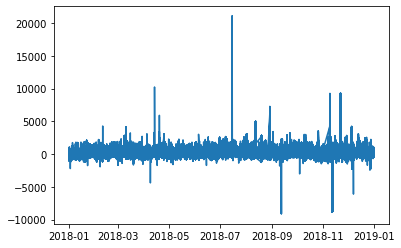

In [44]:
# plot of time series for the sample route chosen
plt.plot(route_pd_df["datetime_exact"], route_pd_df["delay_amount"])
plt.show()

In [ ]:
# this code crashes the kernel everytime i run it, it should  
plt.hist(route_pd_df["delay_amount"])
plt.xticks(route_pd_df["datetime_exact"])
plt.show()

In [45]:
#renaming the columns so that prophet can read them
time_series = route_pd_df[["datetime_exact", "delay_amount"]] 
time_series.columns = ["ds", "y"]

In [46]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [47]:
len(time_series)

1336960

In [48]:
m = Prophet(yearly_seasonality=True)
%time m.fit(time_series)

CPU times: user 6min 31s, sys: 36.8 s, total: 7min 8s
Wall time: 7min 19s


In [55]:
current_time = pd.DataFrame([datetime.now()], columns=["ds"]) 

In [58]:
forecast = m.predict(current_time)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2021-07-06 17:23:53.727602,-8511.387137,-47843.163465,35923.847228


In [60]:
no_out_time_series = no_outlier_df[["datetime_exact", "delay_amount"]]
no_out_time_series.columns = ["ds", "y"]
m1 = Prophet(yearly_seasonality=True)
%time m1.fit(no_out_time_series)

CPU times: user 3min 50s, sys: 25.9 s, total: 4min 16s
Wall time: 4min 17s


In [61]:
current_time = pd.DataFrame([datetime.now()], columns=["ds"]) 
forecast1 = m1.predict(current_time)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
0,2021-07-06 21:06:19.388043,-14263.160717,-43499.069749,16629.362576


## time series conclusion

the model itself is trained on data that is 3 years old and as time goes on the prediction variance will increase as the time of the training data compares to the time of the testing data increases. 

So for our data we should not use a time sereis model, as the time from the time the model has been collected has elapsed too much so from time series analysis, we know was time grows the variance will grow as well, so the variance of the prediction for 2021 will have very high variance which will cause the prediction to be less accurate

#  Choosing a different model

There are other regression models that we can choose from, but the issue with those models is that we cannot take a time series into account.

## random forest

fro random forest i think the best features to use are 

if it is a holiday

day of week

hour of day,  minute of day of the expected arrival at the station

weather data maybe?

I will create two to see the difference. 

the target will renmain the same as the delay of the bus

In [35]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211,NaN,NaN,2018-01-08 17:21:10,2018-01-01 13:00:00,-18,13,20,Monday,1,0,2018-01-01 13:20:30
1,2018-01-01,5966674,12,119,54001,54001,54023,54023,2693267,NaN,NaN,2018-01-08 17:21:10,2018-01-01 15:00:00,22,15,0,Monday,1,0,2018-01-01 15:00:01
2,2018-01-01,5959105,12,119,60001,60001,59955,59955,2693263,NaN,NaN,2018-01-08 17:21:10,2018-01-01 16:00:00,-46,16,40,Monday,1,0,2018-01-01 16:40:01
3,2018-01-01,5966888,12,119,58801,58801,58771,58771,2693284,NaN,NaN,2018-01-08 17:21:10,2018-01-01 16:00:00,-30,16,20,Monday,1,0,2018-01-01 16:20:01
4,2018-01-01,5965960,12,119,56401,56401,56309,56323,2693209,NaN,NaN,2018-01-08 17:21:10,2018-01-01 15:00:00,-92,15,40,Monday,1,0,2018-01-01 15:40:01


In [12]:
# fget the proportion of the time
route_pd_df["time_proportion"] = (route_pd_df["datetime_exact"] - min(route_pd_df["datetime_exact"]))/(max(route_pd_df["datetime_exact"])- min(route_pd_df["datetime_exact"]))

In [13]:
# join the direction into the route
trips_df = dd.read_csv("data/rt_trips_DB_2018.txt", sep = ";")
trips_direction_df = trips_df[["TRIPID", "DIRECTION"]].compute()
route_pd_df = pd.merge(route_pd_df ,trips_direction_df ) 

In [55]:
# train test split with respect to time
train_df = route_pd_df[route_pd_df["time_proportion"] <= 0.7]
test_df = route_pd_df[route_pd_df["time_proportion"] > 0.7]

In [24]:
train_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact,time_proportion,DIRECTION
0,2018-01-01,5957731,2,935,77743,77743,77715,77715,2868314,NaN,...,2018-01-01 21:00:00,-28,21,35,Monday,1,0,2018-01-01 21:35:43,0.001496,1
1,2018-01-01,5957731,1,4381,77700,77700,77683,77683,2868314,NaN,...,2018-01-01 21:00:00,-17,21,35,Monday,1,0,2018-01-01 21:35:00,0.001494,1
2,2018-01-01,5957731,3,936,77765,77765,77727,77727,2868314,NaN,...,2018-01-01 21:00:00,-38,21,36,Monday,1,0,2018-01-01 21:36:05,0.001497,1
3,2018-01-01,5957731,5,914,77854,77854,77805,77805,2868314,NaN,...,2018-01-01 21:00:00,-49,21,37,Monday,1,0,2018-01-01 21:37:34,0.001500,1
4,2018-01-01,5957731,6,938,77886,77886,77830,77830,2868314,NaN,...,2018-01-01 21:00:00,-56,21,38,Monday,1,0,2018-01-01 21:38:06,0.001501,1


In [66]:
# this function does not work after many edist still does not work
# def function(df):
#     try:
#         if df["PROGRNUMBER"] > 1:
#             return df["delay_amount"][df["TRIPID"] == df["TRIPID"]][df["PROGRNUMBER"] - 1 ]
#         else:
#             return 0
#     except IndexError:
#         try:
#             return df["delay_amount"][df["TRIPID"] == df["TRIPID"]][df["PROGRNUMBER"] - 2 ]
#         except IndexError:
#             return df["delay_amount"][df["TRIPID"] == df["TRIPID"]][df["PROGRNUMBER"] - 3]

In [67]:
# %time route_pd_df["previous_delay"] = route_pd_df.apply(function, axis = 1)

TypeError: 'int' object is not subscriptable

In [56]:
# outliers for the target, 30 minutes is decent ourlier, any larger, its scary
no_outlier_train = train_df[abs(train_df["delay_amount"]) < 1800 ]

In [71]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
# one hot encoder
day_of_week_ohc = OneHotEncoder(handle_unknown="ignore")
day_of_week_ohc.fit(no_outlier_train["day_of_week"].values.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [51]:
route_pd_df["suppressed_id"]

KeyError: 'suppressed_id'

In [26]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,date_and_time,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact,time_proportion,DIRECTION
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211,NaN,...,2018-01-01 13:00:00,-18,13,20,Monday,1,0,2018-01-01 13:20:30,0.000382,1
1,2018-01-01,5972116,13,44,48079,48079,48058,48058,2693211,NaN,...,2018-01-01 13:00:00,-21,13,21,Monday,1,0,2018-01-01 13:21:19,0.000384,1
2,2018-01-01,5972116,14,7603,48114,48114,48071,48071,2693211,NaN,...,2018-01-01 13:00:00,-43,13,21,Monday,1,0,2018-01-01 13:21:54,0.000385,1
3,2018-01-01,5972116,15,45,48155,48155,48089,48100,2693211,NaN,...,2018-01-01 13:00:00,-66,13,22,Monday,1,0,2018-01-01 13:22:35,0.000386,1
4,2018-01-01,5972116,16,46,48221,48221,48137,48137,2693211,NaN,...,2018-01-01 13:00:00,-84,13,23,Monday,1,0,2018-01-01 13:23:41,0.000388,1


In [32]:
# get the target and the training features
train_target = train_df["delay_amount"]
test_target = test_df["delay_amount"]
training = train_df[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION"]]
testing = test_df[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION"]]

In [29]:
# save the encoder so that the data encoding is consistent, throughout
pickle.dump(day_of_week_ohc, open("models/days_of_week_one_hot_encoder.sav", 'wb'))

In [26]:
# load the model from disk
loaded_encoder = joblib.load("models/days_of_week_one_hot_encoder.sav")

In [29]:
loaded_encoder.categories_

[array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
        'Wednesday'], dtype=object)]

In [30]:
# if we one hot encode the days of the week
train_days = loaded_encoder.transform(train_df["day_of_week"].values.reshape(-1,1))
test_days = loaded_encoder.transform(test_df["day_of_week"].values.reshape(-1,1))

In [40]:
route_pd_df["encoded_weekdays"] = route_pd_df["day_of_week"].replace({"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7})

In [41]:
route_pd_df.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,VEHICLEID,SUPPRESSED,...,delay_amount,planned_arr_hours,planned_arr_minutes,day_of_week,holiday,suppressed_indicator,datetime_exact,time_proportion,DIRECTION,encoded_weekdays
0,2018-01-01,5972116,12,119,48030,48030,48012,48012,2693211,NaN,...,-18,13,20,Monday,1,0,2018-01-01 13:20:30,0.000382,1,1
1,2018-01-01,5972116,13,44,48079,48079,48058,48058,2693211,NaN,...,-21,13,21,Monday,1,0,2018-01-01 13:21:19,0.000384,1,1
2,2018-01-01,5972116,14,7603,48114,48114,48071,48071,2693211,NaN,...,-43,13,21,Monday,1,0,2018-01-01 13:21:54,0.000385,1,1
3,2018-01-01,5972116,15,45,48155,48155,48089,48100,2693211,NaN,...,-66,13,22,Monday,1,0,2018-01-01 13:22:35,0.000386,1,1
4,2018-01-01,5972116,16,46,48221,48221,48137,48137,2693211,NaN,...,-84,13,23,Monday,1,0,2018-01-01 13:23:41,0.000388,1,1


The columns of the training data for the model with no weather are,

expected time of arrival hours, expected time ofg arrivals minutes, holiday index, suppressed indicator, day of weeks

day of weeks are in the order of friday, monday, saturday, sunday, thursday, tuesday, wednesday

In [44]:
# no weather rf
# target = no_outlier_df["delay_amount"]
# design_matrix_1 = no_outlier_df[["planned_arr_hours", "planned_arr_minutes","PROGRNUMBER", "holiday", "suppressed_indicator"]]
# days_of_week_encoded = day_of_week_ohc.transform(no_outlier_df["day_of_week"].values.reshape(-1,1)).toarray()
# train_X = np.concatenate((design_matrix_1.values,days_of_week_encoded), axis = 1)

In [33]:
# training the model
design_matrix_1 = np.concatenate((training.values, train_days.toarray()), axis = 1)
test_matrix_1 = np.concatenate((testing.values, test_days.toarray()), axis = 1)

In [43]:
# if we do not  one hot encode the weekdays for random forest
train_matrix_2 = train_df[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION"]]
test_matrix_2 = test_df[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION"]]

In [34]:
# training the model
rf_no_weather = RandomForestRegressor(n_estimators = 100,max_depth = 5, n_jobs = -1)
rf_no_weather.fit(design_matrix_1, train_target)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [44]:
# training the model
rf_no_weather2 = RandomForestRegressor(n_estimators = 100,max_depth = 5, n_jobs = -1)
rf_no_weather2.fit(train_matrix_2, train_target)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [36]:
# testiung the model
predicted_values =  rf_no_weather.predict(test_matrix_1)
mae_error = mean_absolute_error(test_target, predicted_values)
print(mae_error)

208.03291090758745


In [45]:
# testiung the model
predicted_values2 =  rf_no_weather2.predict(test_matrix_2)
mae_error2 = mean_absolute_error(test_target, predicted_values2)
print(mae_error2)

207.9699624469228


In [46]:
mse_error2 = mean_squared_error(test_target, predicted_values2, squared = False)
print(mse_error2)

352.5696361952799


The error for no weather has an mean absolute error of 210 seconds which is around 3:40 minutes. 

The mean squared error is around 5-6 minutes

In [38]:
rf_no_weather.feature_importances_

array([6.37989524e-01, 4.21093682e-02, 3.01133355e-03, 1.92715191e-02,
       9.32073362e-03, 2.33354561e-02, 1.66472709e-01, 0.00000000e+00,
       9.49959467e-05, 0.00000000e+00, 9.83943600e-02, 0.00000000e+00])

In [47]:
rf_no_weather2.feature_importances_

array([0.80173075, 0.10702854, 0.04643663, 0.0296339 , 0.01517018])

In [67]:
from sklearn.linear_model import LinearRegression

In [51]:
# fit a linear regression model
lin_reg_no_weather = LinearRegression()
lin_reg_no_weather.fit(design_matrix_1, train_target)

LinearRegression()

In [52]:
predicted_lin = lin_reg_no_weather.predict(test_matrix_1)
lin_reg_mae_error = mean_absolute_error(test_target, predicted_lin)
lin_reg_mse_error = mean_squared_error(test_target, predicted_lin, squared = False)

print(lin_reg_mae_error)
print(lin_reg_mse_error)

210.72648555582177
351.8608638048394


Looking at the feature importance, we see that some of the features dont m ean very much since the weights are given as 0. which means the feature is not very important.



In [73]:
filename = 'models/rf_noweather_{}.sav'.format("route1")

In [74]:
# save the model as a pickel file
pickle.dump(rf_no_weather, open(filename, 'wb'))

In [63]:
# load the model from disk
# loaded_model = joblib.load(filename)

In [24]:
weather_df.head()

,dt,dt_iso,timezone,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2017-12-31 00:00:00,2017-12-31 00:00:00 +0000 UTC,0,283.06,279.56,281.150,285.150,983,93,4.63,140,NaN,NaN,75,803,Clouds,broken clouds,04n
1,2017-12-31 01:00:00,2017-12-31 01:00:00 +0000 UTC,0,284.24,274.44,284.150,284.716,983,82,13.38,230,NaN,NaN,75,803,Clouds,broken clouds,04n
2,2017-12-31 02:00:00,2017-12-31 02:00:00 +0000 UTC,0,284.16,275.52,283.662,284.669,982,76,11.32,220,NaN,NaN,75,803,Clouds,broken clouds,04n
3,2017-12-31 03:00:00,2017-12-31 03:00:00 +0000 UTC,0,283.14,271.20,282.423,283.726,983,62,14.92,240,NaN,NaN,75,803,Clouds,broken clouds,04n
4,2017-12-31 04:00:00,2017-12-31 04:00:00 +0000 UTC,0,281.75,268.11,281.150,282.742,984,61,16.98,240,NaN,NaN,75,803,Clouds,broken clouds,04n


In [25]:
route_pd_df.shape

(1336960, 20)

In [57]:
total_df = pd.merge(route_pd_df, weather_df, left_on = "date_and_time", right_on = "dt")

In [31]:
total_df.shape

(998581, 40)

In [30]:
total_df = total_df.drop_duplicates(["TRIPID", "datetime_exact"])

From the features the trip features that we want to select are the same as the previous model,

The weather data that we should extract would be temperature, rain_1h, weather_main,humidity

In [47]:
total_df.columns

Index(['DAYOFSERVICE', 'TRIPID', 'PROGRNUMBER', 'STOPPOINTID',
       'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR',
       'ACTUALTIME_DEP', 'VEHICLEID', 'SUPPRESSED', 'JUSTIFICATIONID',
       'LASTUPDATE', 'date_and_time', 'delay_amount', 'planned_arr_hours',
       'planned_arr_minutes', 'day_of_week', 'holiday', 'suppressed_indicator',
       'datetime_exact', 'dt', 'dt_iso', 'timezone', 'temp', 'feels_like',
       'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon'],
      dtype='object')

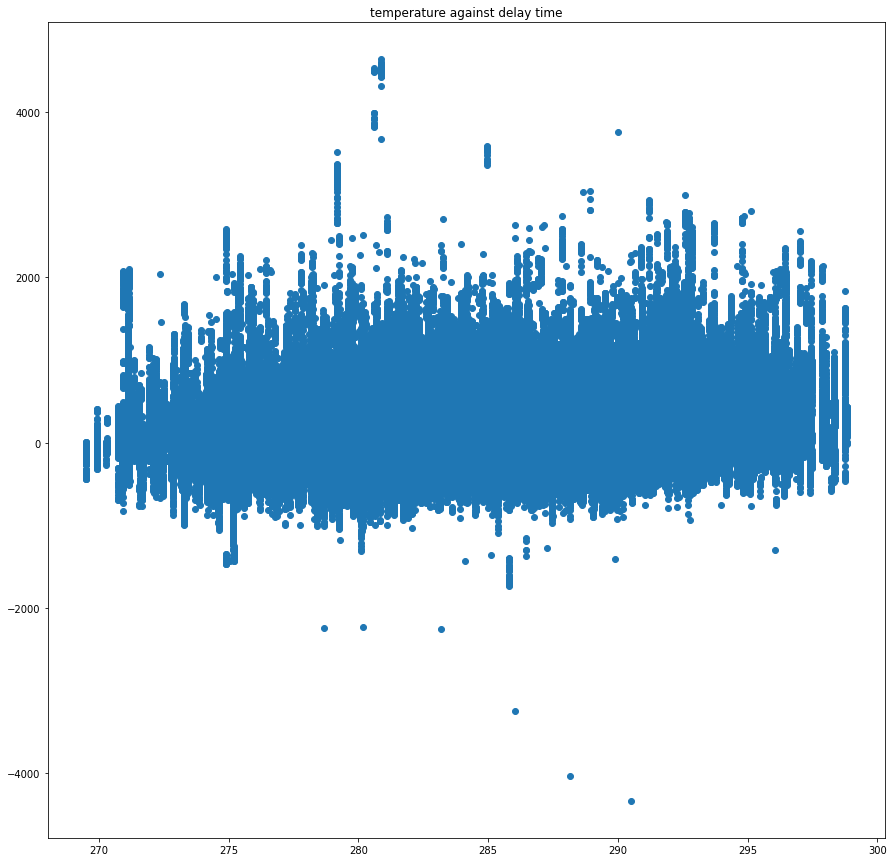

In [34]:
plt.figure(figsize = (15,15))
plt.scatter(total_df["temp"],total_df["delay_amount"])
plt.title("temperature against delay time")
plt.show()

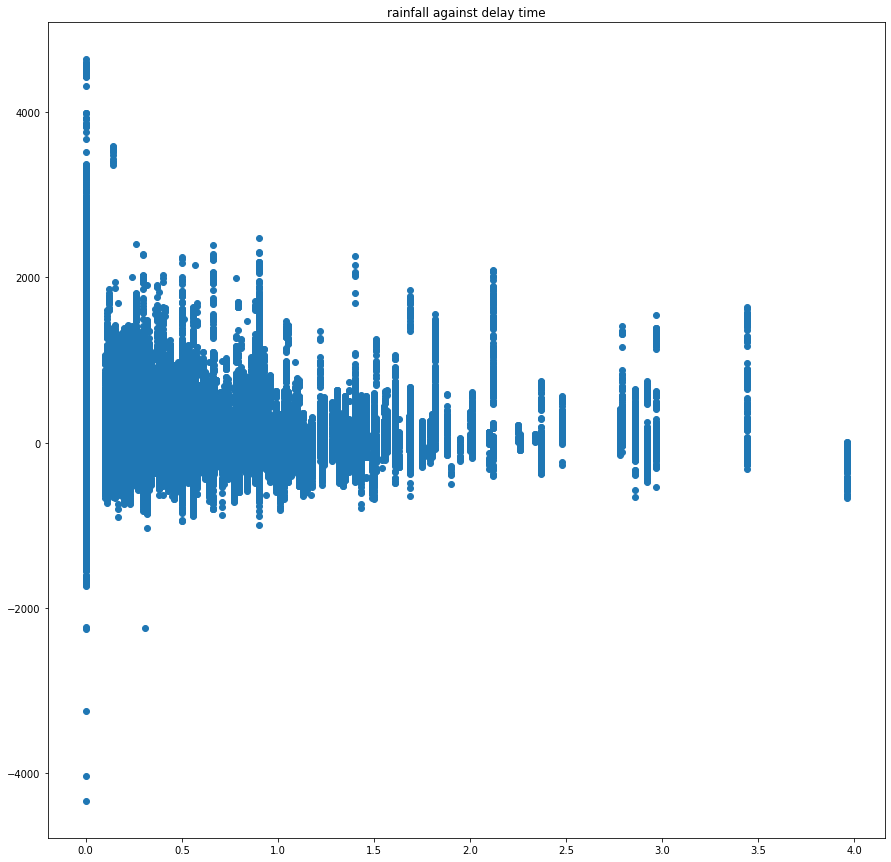

In [35]:
plt.figure(figsize = (15,15))
plt.scatter(total_df["rain_1h"],total_df["delay_amount"])
plt.title("rainfall against delay time")
plt.show()

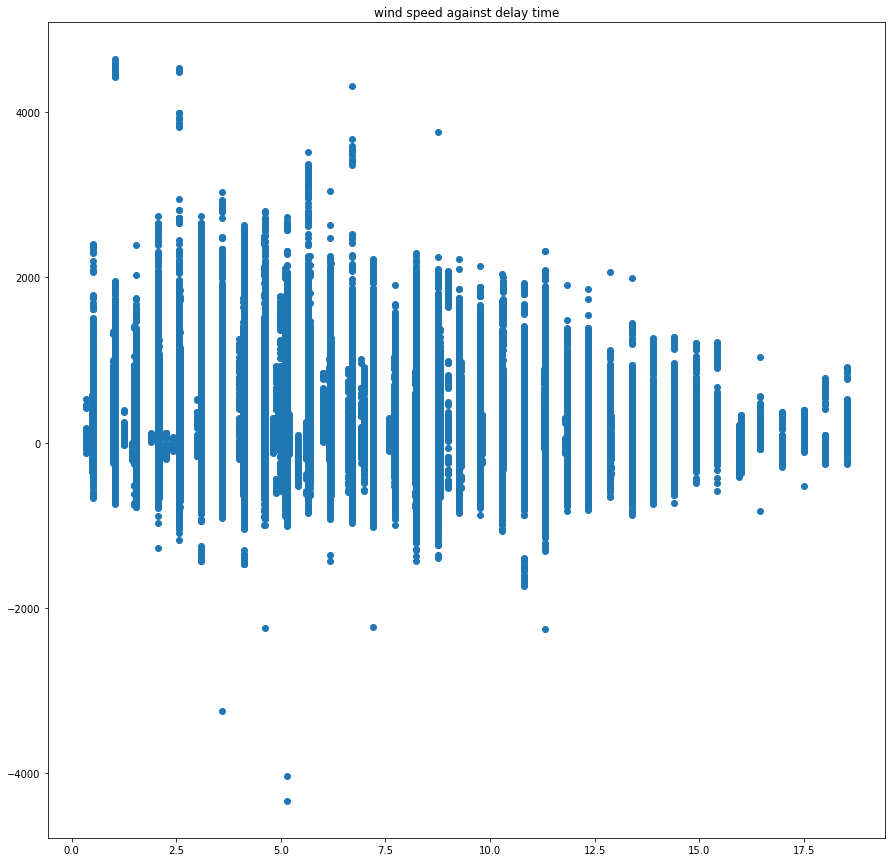

In [36]:
plt.figure(figsize = (15,15))
plt.scatter(total_df["wind_speed"],total_df["delay_amount"])
plt.title("wind speed against delay time")
plt.show()

In [16]:
# load the encoders from disk
loaded_encoder = joblib.load("models/days_of_week_one_hot_encoder.sav")
weather_encoder = joblib.load("models/weather_encoder.sav")

In [37]:
types_of_weather = list(total_df["weather_main"].unique())

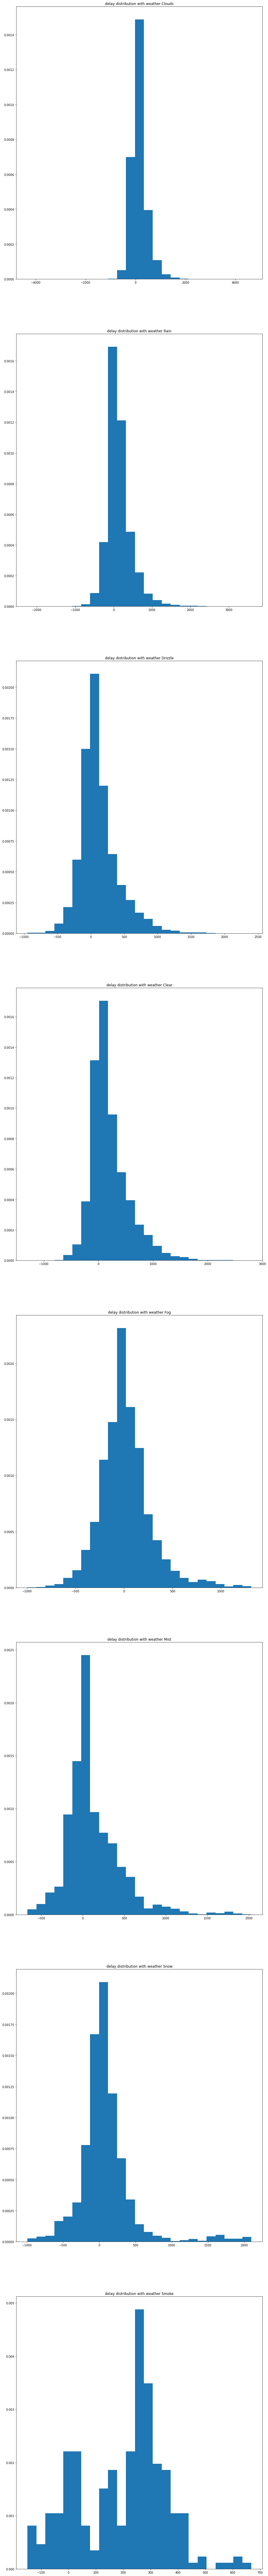

In [33]:
fig, ax = plt.subplots(8, figsize = (15, 20*8))
index = 0
for element in types_of_weather:
    data = total_df[total_df["weather_main"] == element]
    ax[index].hist(data["delay_amount"], bins = 25, density = True)
    ax[index].set_title("delay distribution with weather {}".format(element))
    index += 1

fig.savefig("data/weather_distribution")

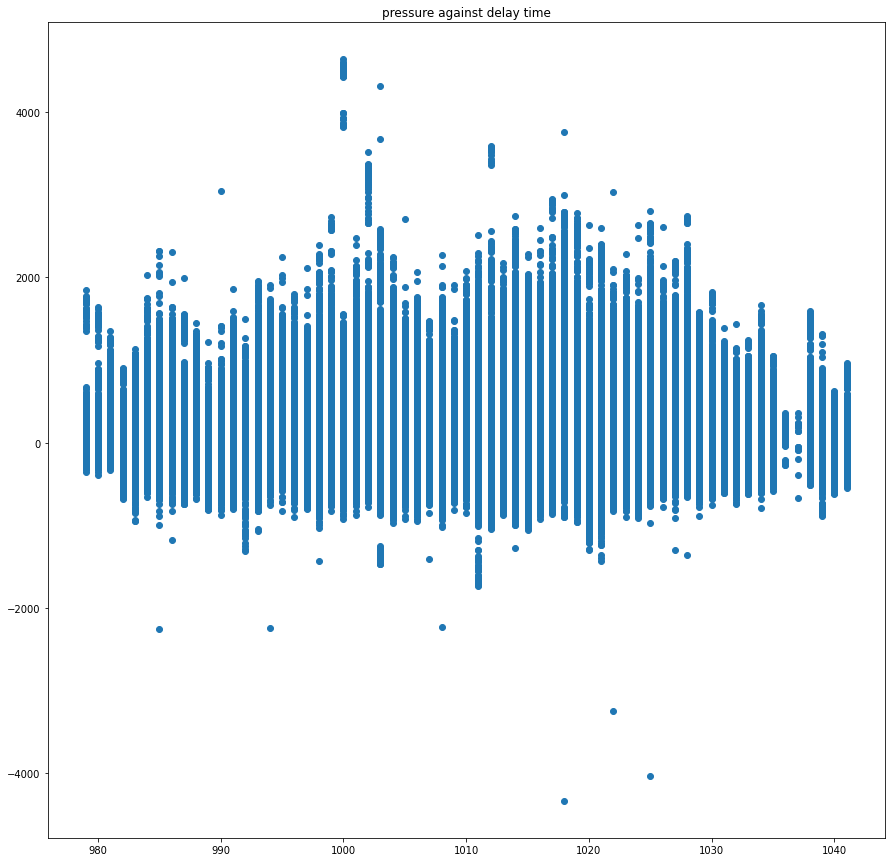

In [38]:
plt.figure(figsize = (15,15))
plt.scatter(total_df["pressure"],total_df["delay_amount"])
plt.title("pressure against delay time")
plt.show()

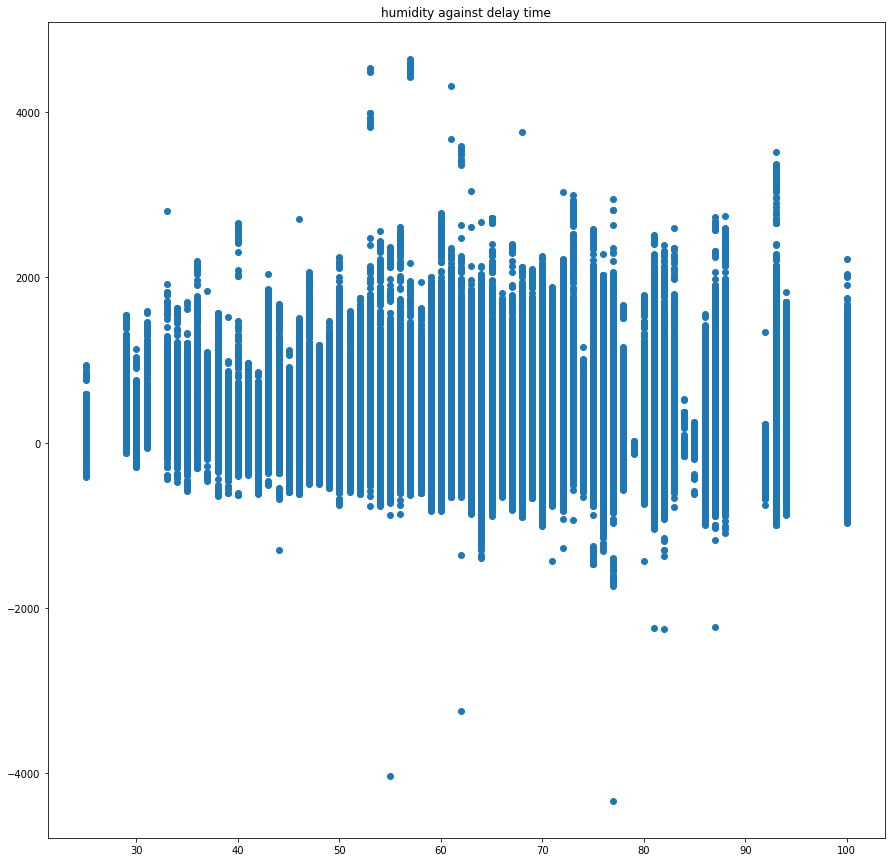

In [39]:
plt.figure(figsize = (15,15))
plt.scatter(total_df["humidity"],total_df["delay_amount"])
plt.title("humidity against delay time")
plt.show()

In [77]:
types_of_weather

['Rain', 'Clouds', 'Drizzle', 'Clear', 'Fog', 'Mist', 'Snow', 'Smoke']

In [80]:
# save the weather encoder
weather_ohc = OneHotEncoder(handle_unknown="ignore")
weather_ohc.fit(np.array(types_of_weather).reshape(-1,1))
pickle.dump(weather_ohc, open("models/weather_encoder.sav", 'wb'))

OneHotEncoder(handle_unknown='ignore')

In [81]:
pickle.dump(weather_ohc, open("models/weather_encoder.sav", 'wb'))

In [101]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8848 entries, 0 to 8847
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   8848 non-null   datetime64[ns]
 1   dt_iso               8848 non-null   object        
 2   timezone             8848 non-null   int64         
 3   temp                 8848 non-null   float64       
 4   feels_like           8848 non-null   float64       
 5   temp_min             8848 non-null   float64       
 6   temp_max             8848 non-null   float64       
 7   pressure             8848 non-null   int64         
 8   humidity             8848 non-null   int64         
 9   wind_speed           8848 non-null   float64       
 10  wind_deg             8848 non-null   int64         
 11  rain_1h              1327 non-null   float64       
 12  snow_1h              65 non-null     float64       
 13  clouds_all           8848 non-nul

In [113]:
weather_df["rain_1h"].describe()

count    8848.000000
mean        0.090674
std         0.295046
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.080000
Name: rain_1h, dtype: float64

In [59]:
weather_train_df = total_df[total_df["time_proportion"] <= 0.7]
weather_test_df = total_df[total_df["time_proportion"] > 0.7]

weather_train_no_out = weather_train_df[weather_train_df["delay_amount"] < 1800]

In [60]:
# extract the features we want

weather_train_no_out["encoded_weekdays"] = weather_train_no_out["day_of_week"].replace({"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7})
weather_test_df["encoded_weekdays"] = weather_test_df["day_of_week"].replace({"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7})

weather_train_target = weather_train_no_out["delay_amount"]
weather_test_target = weather_test_df["delay_amount"]
training = weather_train_no_out[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION","rain_1h", "encoded_weekdays", "suppressed_id"]]
testing = weather_test_df[["PROGRNUMBER", "planned_arr_hours", "planned_arr_minutes", "holiday",  "DIRECTION", "rain_1h", "encoded_weekdays", "suppressed_id"]]

# load the model from disk
loaded_encoder = joblib.load("models/days_of_week_one_hot_encoder.sav")

# if we one hot encode the days of the week
train_days = loaded_encoder.transform(weather_train_no_out["day_of_week"].values.reshape(-1,1))
test_days = loaded_encoder.transform(weather_test_df["day_of_week"].values.reshape(-1,1))



# load the model from disk
weather_encoder = joblib.load("models/days_of_week_one_hot_encoder.sav")
weather_train = weather_encoder.transform(np.array(list(weather_train_no_out["weather_main"])).reshape(-1,1))
weather_test = weather_encoder.transform(np.array(list(weather_test_df["weather_main"])).reshape(-1,1))


# creating the models training the model
design_matrix_1 = np.concatenate((training.values, train_days.toarray(), weather_train.toarray()), axis = 1)
test_matrix_1 = np.concatenate((testing.values, test_days.toarray(), weather_test.toarray()), axis = 1)

design_matrix_2 = np.concatenate((training.values, weather_train.toarray()), axis = 1)
test_matrix_2 = np.concatenate((testing.values, weather_test.toarray()), axis = 1)



<ipython-input-60-bca53b7ecfc2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_train_no_out["encoded_weekdays"] = weather_train_no_out["day_of_week"].replace({"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7})
<ipython-input-60-bca53b7ecfc2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_test_df["encoded_weekdays"] = weather_test_df["day_of_week"].replace({"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6, "Sunday":7}

In [61]:
design_matrix_1.shape

(4444933, 22)

In [35]:
design_matrix_2.shape

(4121726, 14)

In [47]:
(-4121726 + 4444933)/4444933

0.0727135819595031

In [62]:
rf_weather = RandomForestRegressor(n_estimators = 200, max_depth = 5, n_jobs = -1, oob_score = True)
rf_weather.fit(design_matrix_1, weather_train_target)

RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, oob_score=True)

In [65]:
rf_weather.feature_importance

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_importance'

In [54]:
rf_weather2 = RandomForestRegressor(n_estimators = 200, max_depth = 5, n_jobs = -1, oob_score = True)
rf_weather2.fit(design_matrix_2, weather_train_target)

RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, oob_score=True)

In [63]:
predicted_values = rf_weather.predict(test_matrix_1)
mae_error = mean_absolute_error(weather_test_target, predicted_values)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, predicted_values, squared = False)
print(mse_error)

210.34724280338912
302.10831939441175


In [64]:
print(predicted_values.mean())

132.98044920078414


In [78]:
print(weather_test_target.mean())

150.16596758677477


(array([2.16644933e-08, 0.00000000e+00, 0.00000000e+00, 1.08322467e-08,
        0.00000000e+00, 2.16644933e-08, 8.23250746e-07, 3.14135153e-07,
        2.38309426e-07, 4.23974134e-06, 3.45851971e-05, 2.14549977e-04,
        1.32221436e-03, 1.38780794e-03, 5.82902690e-04, 2.60504700e-04,
        9.78498505e-05, 3.72001015e-05, 1.46885265e-05, 7.13411765e-06]),
 array([-3245. , -2992.8, -2740.6, -2488.4, -2236.2, -1984. , -1731.8,
        -1479.6, -1227.4,  -975.2,  -723. ,  -470.8,  -218.6,    33.6,
          285.8,   538. ,   790.2,  1042.4,  1294.6,  1546.8,  1799. ]),
 <BarContainer object of 20 artists>)

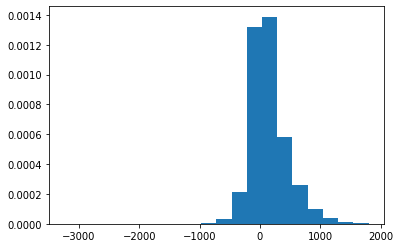

In [82]:
plt.hist(weather_test_target[weather_test_target < 1800], bins = 20, density = True)

(array([ 11817.,      0.,      0.,      0.,      0.,  13961.,   2404.,
         11641.,  20248.,  28969.,   3624.,  12020., 109529.,  56435.,
        501326., 810086.,  21882.,  80484., 141333.,   6888.]),
 array([-265.82847731, -242.67811481, -219.52775231, -196.37738981,
        -173.22702731, -150.07666481, -126.92630231, -103.77593981,
         -80.62557731,  -57.47521481,  -34.32485231,  -11.17448981,
          11.97587268,   35.12623518,   58.27659768,   81.42696018,
         104.57732268,  127.72768518,  150.87804768,  174.02841018,
         197.17877268]),
 <BarContainer object of 20 artists>)

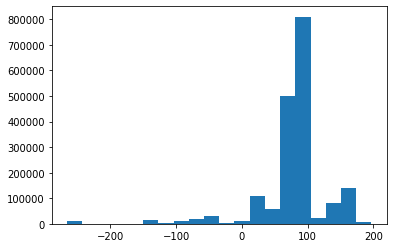

In [40]:
import matplotlib.pyplot as plt
plt.hist(predicted_values, bins = 20)

In [56]:
predicted_values = rf_weather2.predict(test_matrix_2)
mae_error = mean_absolute_error(weather_test_target, predicted_values)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, predicted_values, squared = False)
print(mse_error)

209.4288634361546
304.4014695123909


In [68]:
lin_reg_weather1 = LinearRegression()
lin_reg_weather1.fit(design_matrix_1, weather_train_target)

# lin_reg_weather2 = LinearRegression()
# lin_reg_weather2.fit(design_matrix_2, weather_train_target)

LinearRegression()

In [69]:
lin_values1 = lin_reg_weather1.predict(test_matrix_1)
mae_error = mean_absolute_error(weather_test_target, lin_values1)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, lin_values1, squared = False)
print(mse_error)

217.2001788841863
310.945711170025


In [80]:
print(lin_values1.mean())

132.5401178596435


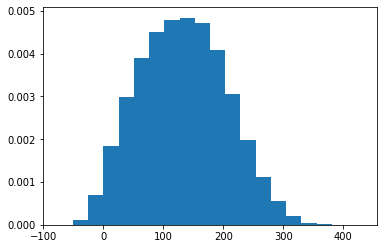

In [77]:
plt.hist(lin_values1, bins = 20, density = True)
plt.show()

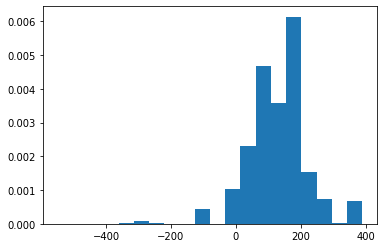

In [75]:
plt.hist(predicted_values, bins = 20, density = True)
plt.show()

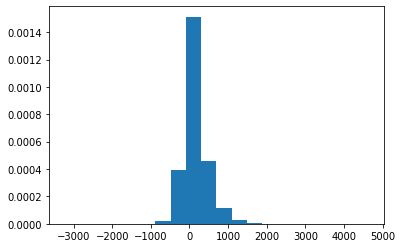

In [76]:
plt.hist(weather_test_target, bins = 20, density = True)
plt.show()

In [50]:
lin_values2 = lin_reg_weather2.predict(test_matrix_2)
mae_error = mean_absolute_error(weather_test_target, lin_values2)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, lin_values2, squared = False)
print(mse_error)

213.5566561167923
310.18946379658104


In [178]:
from sklearn.linear_model import Ridge

In [179]:
ridge1 = Ridge(alpha = 0.5)
ridge1.fit(design_matrix_1, weather_train_target)

ridge2 = Ridge(alpha = 0.5)
ridge2.fit(design_matrix_2, weather_train_target)

Ridge(alpha=0.5)

In [181]:
predicted_values = ridge1.predict(test_matrix_1)
mae_error = mean_absolute_error(weather_test_target, predicted_values)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, predicted_values, squared = False)
print(mse_error)

212.61148800440714
349.2363176319028


In [180]:
predicted_values = ridge2.predict(test_matrix_2)
mae_error = mean_absolute_error(weather_test_target, predicted_values)
print(mae_error)
mse_error = mean_squared_error(weather_test_target, predicted_values, squared = False)
print(mse_error)

213.5280712097019
352.30610737637136


In [ ]:
from sklearn import svm

In [ ]:
# we could also use a svm for the regression task at hand.
# but due to the large number of datapoints
# the model may niot be such a good idea as it may crash in the training process.
svm1 = svm.SVR(verbose = True)
svm1.fit(design_matrix_1, weather_train_target)

svm2 = svm.SVR(verbose = True)
svm2.fit(design_matrix_2, weather_train_target)